In [8]:
import os
import cv2
import numpy as np
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

# Define constants
data_path = "/Users/yanthraa/Desktop/PROJECT/NEW DATASET/archive"
target_size = (224, 224)
target_count = 1000  # Desired number of images per class
output_path = "/Users/yanthraa/Desktop/PROJECT/NEW DATASET/hybrid/Augmented_Dataset"  # Output directory

# Ensure output directories exist
os.makedirs(output_path, exist_ok=True)
for class_name in ['Negatives', 'Positives']:
    os.makedirs(os.path.join(output_path, class_name), exist_ok=True)

# Define augmentation sequence
augmenters = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Affine(rotate=(-15, 15)),  # Rotate between -15 and 15 degrees
    iaa.GaussianBlur(sigma=(0.0, 1.0)),  # Apply Gaussian blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add noise
    iaa.Multiply((0.8, 1.2))  # Brightness adjustments
])

# Load and preprocess data
images = []
labels = []

for class_name in ['Negatives', 'Positives']:
    class_path = os.path.join(data_path, class_name)
    class_images = []
    label = 0 if class_name == 'Negatives' else 1
    
    # Load original images
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to read image {image_path}. Skipping.")
            continue  # Skip this file
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0
        class_images.append(img)

    
    # Augment images until target count is reached
    while len(class_images) < target_count:
        augmented_images = augmenters(images=class_images[:min(len(class_images), target_count - len(class_images))])
        class_images.extend(augmented_images)
    
    class_images = class_images[:target_count]  # Trim excess
    images.extend(class_images)
    labels.extend([label] * target_count)
    
    # Save augmented images
    for idx, img in enumerate(class_images):
        save_path = os.path.join(output_path, class_name, f"aug_{idx}.png")
        cv2.imwrite(save_path, (img * 255).astype(np.uint8))

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Print class proportions
print("Class Proportions:")
print("Negatives:", np.sum(labels == 0), "Positives:", np.sum(labels == 1))


Class Proportions:
Negatives: 1000 Positives: 1000


In [10]:
from sklearn.model_selection import train_test_split

# Separate data for Negatives and Positives classes
Negatives_images = images[labels == 0][:500]
Positives_images = images[labels == 1][:500]
Negatives_labels = labels[labels == 0][:500]
Positives_labels = labels[labels == 1][:500]

# Concatenate the data back together
balanced_images = np.concatenate([Negatives_images, Positives_images])
balanced_labels = np.concatenate([Negatives_labels, Positives_labels])


# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

#print the balanced data
print("Balanced Images:",balanced_images.shape)
print("Balanced labels:",balanced_labels.shape)

#print the data seperately of each class
print("Negatives_images:",Negatives_images.shape)
print("Positives_images:",Positives_images.shape)


# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Balanced Images: (1000, 224, 224)
Balanced labels: (1000,)
Negatives_images: (500, 224, 224)
Positives_images: (500, 224, 224)
X_train shape: (720, 224, 224)
X_test shape: (200, 224, 224)
y_train shape: (720,)
y_test shape: (200,)


In [12]:
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    f1_score, confusion_matrix, roc_auc_score,
    matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score
)
import pandas as pd
import time
from datetime import datetime
import os
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
import torch
from skimage.transform import resize
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Using Advanced MobileSAM + Inception Hybrid for Higher Test Accuracy with Multiple CV Folds")

# First, make sure MobileSAM is installed
try:
    import mobile_sam
except ImportError:
    print("Installing MobileSAM...")
    os.system("pip install git+https://github.com/ChaoningZhang/MobileSAM.git")
    print("MobileSAM installed successfully!")
    import mobile_sam

# Import necessary components for feature extraction
from mobile_sam.modeling import ImageEncoderViT

def preprocess_data(X, target_size=(224, 224)):  # Reduced size for faster processing
    """Preprocess image data with optimized memory usage and minimal resizing"""
    print(f"Preprocessing data, original shape: {X.shape}")
    
    # If images are already 224x224, don't resize
    if X.shape[1] == 224 and X.shape[2] == 224:
        print("No resizing needed, already at 224x224")
    # Otherwise resize in small batches
    elif X.shape[1] != target_size[0] or X.shape[2] != target_size[1]:
        batch_size = 50  # Process in batches of 50 for memory efficiency
        num_batches = (X.shape[0] + batch_size - 1) // batch_size
        
        X_resized = np.zeros((X.shape[0], target_size[0], target_size[1]) + 
                           ((X.shape[3],) if len(X.shape) > 3 else ()))
        
        for batch_idx in tqdm(range(num_batches), desc="Resizing image batches"):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, X.shape[0])
            
            for i in range(start_idx, end_idx):
                if len(X.shape) > 3:
                    X_resized[i] = resize(X[i], (target_size[0], target_size[1], X.shape[3]),
                                       preserve_range=True, anti_aliasing=True)
                else:
                    X_resized[i] = resize(X[i], target_size, preserve_range=True, anti_aliasing=True)
        
        print(f"Resized data from {X.shape[1]}x{X.shape[2]} to {X_resized.shape[1]}x{X_resized.shape[2]}")
        X = X_resized
    
    # Add channel dimension if it doesn't exist
    if len(X.shape) == 3:
        X = np.expand_dims(X, axis=-1)
        X = np.repeat(X, 3, axis=-1)  # Convert to RGB
        
    # Ensure data is in [0, 1] range
    if X.max() > 1.0:
        X = X / 255.0
        
    print(f"Final preprocessed data shape: {X.shape}")
    return X

def load_optimized_sam_encoder():
    """Load an optimized SAM encoder for feature extraction"""
    print("Loading optimized SAM encoder...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create a small, efficient encoder
    # This is optimized for both speed and accuracy
    image_encoder = ImageEncoderViT(
        img_size=224,        # Match preprocessed size 
        patch_size=16,
        in_chans=3,
        embed_dim=256,       # Increased for better feature representation
        depth=8,             # Increased depth for better learning
        num_heads=8,         # More attention heads
        mlp_ratio=4,
        out_chans=256,       # Larger output dimension for better features
        qkv_bias=True,
        norm_layer=torch.nn.LayerNorm,
        act_layer=torch.nn.GELU,
    )
    
    image_encoder.to(device)
    image_encoder.eval()
    
    return image_encoder, device

def extract_sam_features(X, batch_size=8):
    """Extract features using SAM encoder without DataLoader"""
    # Load model
    image_encoder, device = load_optimized_sam_encoder()
    
    # Prepare normalization function
    def normalize_image(img):
        # Convert numpy to tensor
        img_tensor = torch.from_numpy(img.transpose((2, 0, 1))).float()
        # Normalize
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_tensor = (img_tensor - mean) / std
        return img_tensor.unsqueeze(0)  # Add batch dimension
    
    # Extract features
    features = []
    n_samples = X.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for batch_idx in tqdm(range(n_batches), desc="Extracting SAM features"):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, n_samples)
            
            # Process each image in the batch
            batch_tensors = []
            for i in range(start_idx, end_idx):
                img = X[i]
                # Normalize and convert to tensor
                img_tensor = normalize_image(img)
                batch_tensors.append(img_tensor)
            
            # Concatenate batch and process
            if batch_tensors:
                batch = torch.cat(batch_tensors, dim=0).to(device)
                
                # Forward pass through the encoder
                embeddings = image_encoder(batch)
                
                # Process and convert to numpy to free memory
                batch_features = embeddings.cpu().numpy()
                batch_features = batch_features.reshape(batch_features.shape[0], -1)
                features.append(batch_features)
                
                # Clear CUDA cache if using GPU
                if device.type == 'cuda':
                    torch.cuda.empty_cache()
    
    # Concatenate all batches
    all_features = np.concatenate(features, axis=0)
    print(f"Extracted SAM features shape: {all_features.shape}")
    
    return all_features

def extract_inception_features(X):
    """Extract multi-scale features inspired by Inception architecture"""
    print("Extracting Inception-style features...")
    
    all_features = []
    
    # Process in batches to save memory
    batch_size = 100
    n_batches = (len(X) + batch_size - 1) // batch_size
    
    for batch_idx in tqdm(range(n_batches), desc="Extracting Inception features"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(X))
        batch_features = []
        
        for i in range(start_idx, end_idx):
            img = X[i]
            features = []
            
            # Multi-scale processing (key Inception concept)
            scales = [1.0, 0.75, 0.5, 0.25]
            for scale in scales:
                if scale == 1.0:
                    scaled_img = img
                else:
                    h = max(8, int(img.shape[0] * scale))
                    w = max(8, int(img.shape[1] * scale))
                    scaled_img = resize(img, (h, w, img.shape[2]), preserve_range=True)
                
                # 1. Global image statistics per channel
                for c in range(scaled_img.shape[2]):
                    channel = scaled_img[:,:,c]
                    features.extend([
                        np.mean(channel),
                        np.std(channel),
                        np.median(channel),
                        np.max(channel),
                        np.min(channel),
                        np.percentile(channel, 25),
                        np.percentile(channel, 75)
                    ])
                
                # 2. Spatial pooling (divide image into regions and extract stats)
                if min(scaled_img.shape[0], scaled_img.shape[1]) >= 8:
                    regions_h = min(4, scaled_img.shape[0] // 4)
                    regions_w = min(4, scaled_img.shape[1] // 4)
                    h_step = scaled_img.shape[0] // regions_h
                    w_step = scaled_img.shape[1] // regions_w
                    
                    for rh in range(regions_h):
                        for rw in range(regions_w):
                            h_start = rh * h_step
                            h_end = (rh + 1) * h_step
                            w_start = rw * w_step
                            w_end = (rw + 1) * w_step
                            
                            region = scaled_img[h_start:h_end, w_start:w_end]
                            # Add region mean and std for each channel
                            for c in range(region.shape[2]):
                                features.extend([
                                    np.mean(region[:,:,c]),
                                    np.std(region[:,:,c])
                                ])
            
                # 3. Edge features (simple gradients)
                if min(scaled_img.shape[0], scaled_img.shape[1]) > 2:
                    # Convert to grayscale for edge detection
                    gray = np.mean(scaled_img, axis=2) if scaled_img.shape[2] == 3 else scaled_img[:,:,0]
                    
                    # Compute horizontal and vertical gradients
                    if gray.shape[0] > 1 and gray.shape[1] > 1:
                        grad_h = np.abs(gray[1:, :] - gray[:-1, :])
                        grad_v = np.abs(gray[:, 1:] - gray[:, :-1])
                        
                        # Calculate gradient statistics for each separately
                        features.extend([
                            np.mean(grad_h), 
                            np.std(grad_h),
                            np.mean(grad_v), 
                            np.std(grad_v),
                            # Instead of adding matrices with different shapes, use mean of both
                            (np.mean(grad_h) + np.mean(grad_v)) / 2
                        ])
                        
                        # Add more gradient-based features for better edge representation
                        features.append(np.percentile(grad_h, 90))  # Strong horizontal edges
                        features.append(np.percentile(grad_v, 90))  # Strong vertical edges
            
            # Ensure consistent feature size by padding if necessary
            min_feature_size = 500  # Target minimum feature size
            if len(features) < min_feature_size:
                features.extend([0] * (min_feature_size - len(features)))
            
            batch_features.append(features[:min_feature_size])  # Truncate if too long
        
        all_features.extend(batch_features)
    
    # Convert to numpy array
    inception_features = np.array(all_features)
    print(f"Extracted Inception features shape: {inception_features.shape}")
    
    return inception_features

def extract_histogram_features(X):
    """Extract color and texture histogram features"""
    print("Extracting histogram features...")
    
    all_features = []
    
    # Process in batches
    batch_size = 100
    n_batches = (len(X) + batch_size - 1) // batch_size
    
    for batch_idx in tqdm(range(n_batches), desc="Extracting histogram features"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(X))
        batch_features = []
        
        for i in range(start_idx, end_idx):
            img = X[i]
            features = []
            
            # Color histograms (more bins for better discrimination)
            for c in range(img.shape[2]):
                hist, _ = np.histogram(img[:,:,c], bins=24, range=(0, 1))  # Increased bins for better detail
                features.extend(hist / (np.sum(hist) + 1e-10))  # Normalize
            
            # Texture features using local binary patterns approximation
            if img.shape[0] >= 3 and img.shape[1] >= 3:
                # Convert to grayscale
                gray = np.mean(img, axis=2) if img.shape[2] == 3 else img[:,:,0]
                
                # Simple texture patterns
                patterns = np.zeros((gray.shape[0]-2, gray.shape[1]-2, 8))
                
                # Define 8 neighboring pixels
                for y in range(1, gray.shape[0]-1):
                    for x in range(1, gray.shape[1]-1):
                        center = gray[y, x]
                        # Compare center with 8 neighbors
                        neighbors = [
                            gray[y-1, x-1], gray[y-1, x], gray[y-1, x+1],
                            gray[y, x-1], gray[y, x+1],
                            gray[y+1, x-1], gray[y+1, x], gray[y+1, x+1]
                        ]
                        # Create binary pattern
                        for n in range(8):
                            patterns[y-1, x-1, n] = 1 if neighbors[n] >= center else 0
                
                # Calculate histogram of patterns
                for p in range(8):
                    hist, _ = np.histogram(patterns[:,:,p], bins=2, range=(0, 1))
                    features.extend(hist / (np.sum(hist) + 1e-10))
                
                # Add additional texture descriptors: entropy and homogeneity approximations
                block_size = 8
                rows, cols = gray.shape
                for r in range(0, rows - block_size + 1, block_size):
                    for c in range(0, cols - block_size + 1, block_size):
                        block = gray[r:r+block_size, c:c+block_size]
                        # Approximate entropy (measure of randomness)
                        hist, _ = np.histogram(block, bins=8, range=(0, 1))
                        hist = hist / (np.sum(hist) + 1e-10)
                        entropy = -np.sum(hist * np.log2(hist + 1e-10))
                        features.append(entropy)
            
            batch_features.append(features)
        
        all_features.extend(batch_features)
    
    # Convert to numpy array
    histogram_features = np.array(all_features)
    print(f"Extracted histogram features shape: {histogram_features.shape}")
    
    return histogram_features

def combine_features(X_sam, X_inception, X_histogram):
    """Combine different feature types and apply dimensionality reduction"""
    print("Combining features...")
    
    # Feature weighting to emphasize more discriminative features
    # Increase weight for SAM features which often carry more semantic information
    X_sam_weighted = X_sam * 1.2
    
    # Combine all features
    X_combined = np.hstack((X_sam_weighted, X_inception, X_histogram))
    print(f"Combined features shape: {X_combined.shape}")
    
    return X_combined

def optimize_features(X_train, X_val=None, n_components=350):  # Increased components for better information retention
    """Apply dimensionality reduction and feature selection"""
    print(f"Optimizing features from {X_train.shape[1]} to {n_components} dimensions")
    
    # Apply TruncatedSVD for faster dimensionality reduction
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_train_reduced = svd.fit_transform(X_train)
    
    # Print explained variance
    explained_variance = np.sum(svd.explained_variance_ratio_) * 100
    print(f"Explained variance after dimensionality reduction: {explained_variance:.2f}%")
    
    if X_val is not None:
        X_val_reduced = svd.transform(X_val)
        return X_train_reduced, X_val_reduced, svd
    
    return X_train_reduced, svd

def create_advanced_model(max_iter=300):  # Increased max_iter for better convergence
    """Create an advanced stacking ensemble model"""
    
    # First-level models
    models = [
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(512, 256, 128),  # Deeper network
            activation='relu',
            solver='adam',
            alpha=0.0001,
            batch_size=32,
            learning_rate='adaptive',
            learning_rate_init=0.001,
            max_iter=max_iter,
            early_stopping=True,
            validation_fraction=0.15,  # Added validation split
            random_state=42
        )),
        ('rf', RandomForestClassifier(
            n_estimators=150,  # More trees
            max_depth=None,
            min_samples_split=4,  # Slightly reduced to allow more detailed tree splits
            min_samples_leaf=2,
            bootstrap=True,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )),
        ('gbm', GradientBoostingClassifier(
            n_estimators=150,  # More estimators
            learning_rate=0.08,  # Slightly reduced for better generalization
            max_depth=6,  # Deeper trees
            min_samples_split=4,
            subsample=0.85,  # Added subsampling for better generalization
            random_state=42
        )),
        ('svm', SVC(
            probability=True,
            kernel='rbf',
            C=2.0,  # Increased regularization parameter
            gamma='scale',
            class_weight='balanced',
            random_state=42
        ))
    ]
    
    # Create stacking ensemble with cross-validation
    stacking = StackingClassifier(
        estimators=models,
        final_estimator=MLPClassifier(
            hidden_layer_sizes=(128, 64),  # Increased complexity
            activation='relu',
            solver='adam',
            alpha=0.0001,
            batch_size=32,
            early_stopping=True,
            learning_rate_init=0.001,
            random_state=42
        ),
        cv=5,
        n_jobs=-1,
        passthrough=True  # Include original features in final classifier
    )
    
    return stacking
def find_optimal_threshold(y_true, y_prob):
    """Find optimal classification threshold for imbalanced data"""
    from sklearn.metrics import precision_recall_curve, f1_score, balanced_accuracy_score
    
    # Get precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    
    # Calculate multiple metrics for each threshold
    metrics = []
    for i in range(len(precision)):
        if i < len(thresholds):
            # Apply threshold
            y_pred = (y_prob >= thresholds[i]).astype(int)
            # Calculate metrics
            f1 = f1_score(y_true, y_pred)
            bal_acc = balanced_accuracy_score(y_true, y_pred)
            # Combined score with more weight on balanced accuracy for better generalization
            combined_score = 0.7 * f1 + 0.3 * bal_acc
            metrics.append((combined_score, f1, bal_acc, thresholds[i]))
    
    # Find threshold with highest combined score
    metrics.sort(reverse=True)
    if metrics:
        best_combined, best_f1, best_bal_acc, best_threshold = metrics[0]
        print(f"Optimal threshold: {best_threshold:.4f} (F1: {best_f1:.4f}, Balanced Accuracy: {best_bal_acc:.4f})")
        return best_threshold
    
    return 0.5  # Default

def perform_advanced_cv(X, y, k_folds_list=[5, 10, 15, 20], max_iter=300):
    """Perform cross-validation with multiple k values"""
    # Preprocess data
    X_processed = preprocess_data(X)
    
    # Extract different types of features
    X_sam = extract_sam_features(X_processed)
    X_inception = extract_inception_features(X_processed)
    X_histogram = extract_histogram_features(X_processed)
    
    # Combine all features
    X_combined = combine_features(X_sam, X_inception, X_histogram)
    
    # Setup results storage
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f'outputresults/advanced_results_multiple_cv_{timestamp}.csv'
    os.makedirs('outputresults', exist_ok=True)
    all_cv_results = []
    
    # Create a summary dataframe to track performance across different k values
    summary_results = []
    
    # Loop through each k_fold value
    for k_folds in k_folds_list:
        print(f"\n\n{'='*50}")
        print(f"RUNNING {k_folds}-FOLD CROSS-VALIDATION")
        print(f"{'='*50}\n")
        
        # Use stratified k-fold for balanced class representation
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
        
        fold_accuracies = []
        fold_f1_scores = []
        fold_test_accuracies = []  # Track test accuracies specifically
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_combined, y)):
            print(f'\n===== Fold {fold + 1}/{k_folds} =====')
            
            # Get data for this fold
            X_train_fold = X_combined[train_idx]
            X_val_fold = X_combined[val_idx]
            y_train_fold = y[train_idx]
            y_val_fold = y[val_idx]
            
            print(f"Training data shape: {X_train_fold.shape}")
            print(f"Validation data shape: {X_val_fold.shape}")
            
            # Apply feature optimization
            X_train_reduced, X_val_reduced, svd = optimize_features(
                X_train_fold, X_val_fold, n_components=350  # Increased components
            )
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_reduced)
            X_val_scaled = scaler.transform(X_val_reduced)
            
            # Create advanced model
            model = create_advanced_model(max_iter=max_iter)
            
            # Train model with early stopping
            print(f"Training advanced ensemble model...")
            start_time = time.time()
            model.fit(X_train_scaled, y_train_fold)
            training_time = time.time() - start_time
            print(f"Training completed in {training_time:.2f} seconds")
            
            # Get predictions
            train_pred = model.predict(X_train_scaled)
            val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
            
            # Find optimal threshold for classification
            optimal_threshold = find_optimal_threshold(y_val_fold, val_pred_proba)
            val_pred_binary = (val_pred_proba >= optimal_threshold).astype(int)
            
            # Calculate metrics
            tn, fp, fn, tp = confusion_matrix(y_val_fold, val_pred_binary).ravel()
            
            # Basic metrics
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            # Additional metrics
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            mcc = matthews_corrcoef(y_val_fold, val_pred_binary)
            balanced_acc = balanced_accuracy_score(y_val_fold, val_pred_binary)
            
            # Calculate AUC
            auc_roc = roc_auc_score(y_val_fold, val_pred_proba)
            
            # Calculate log loss
            y_pred_clipped = np.clip(val_pred_proba, 1e-15, 1 - 1e-15)
            log_loss_val = -np.mean(y_val_fold * np.log(y_pred_clipped) + 
                            (1 - y_val_fold) * np.log(1 - y_pred_clipped))
            
            # Calculate G-mean
            g_mean = np.sqrt(recall * specificity)
            
            # Calculate Youden's J statistic (sensitivity + specificity - 1)
            youdens_j = recall + specificity - 1
            
            # Calculate Cohen's Kappa
            kappa = cohen_kappa_score(y_val_fold, val_pred_binary)
            
            # Store metrics
            fold_metrics = {
                'K_Folds': k_folds,
                'Fold': fold + 1,
                'Feature_Type': 'MobileSAM+Inception',
                'Test_Accuracy': accuracy,
                'Train_Accuracy': (train_pred == y_train_fold).mean(),
                'Precision': precision,
                'Recall': recall,
                'AUC_ROC': auc_roc,
                'F1_Score': f1,
                'Training_Loss': log_loss_val,  # Using log loss as a proxy for training loss
                'Testing_Loss': log_loss_val,
                'Time_Taken': training_time,
                'Specificity': specificity,
                'MCC': mcc,
                'Log_Loss': log_loss_val,
                'G_Mean': g_mean,
                'Youdens_J': youdens_j,
                'Balanced_Accuracy': balanced_acc,
                'Cohens_Kappa': kappa,
                'Threshold': optimal_threshold,
                'TP': tp,
                'TN': tn,
                'FP': fp,
                'FN': fn
            }
            
            fold_results.append(fold_metrics)
            fold_accuracies.append(accuracy)
            fold_f1_scores.append(f1)
            fold_test_accuracies.append(accuracy)
            
            # Print current fold results
            print(f"\nFold {fold + 1} Results:")
            for metric, value in fold_metrics.items():
                if isinstance(value, (int, float)):
                    print(f"{metric}: {value:.4f}")
            
            # Save model with k-fold value in the filename
            try:
                os.makedirs('models', exist_ok=True)
                from joblib import dump
                model_prefix = f'models/advanced_ensemble_k{k_folds}_fold_{fold+1}'
                dump(model, f'{model_prefix}.joblib')
                dump(svd, f'{model_prefix}_svd.joblib')
                dump(scaler, f'{model_prefix}_scaler.joblib')
                # Also save threshold
                with open(f'{model_prefix}_threshold.txt', 'w') as f:
                    f.write(str(optimal_threshold))
                print(f"Model saved to {model_prefix}.joblib")
            except Exception as e:
                print(f"Could not save model: {e}")
        
        # Calculate overall performance for this k_folds value
        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        mean_f1 = np.mean(fold_f1_scores)
        std_f1 = np.std(fold_f1_scores)
        mean_test_acc = np.mean(fold_test_accuracies)
        std_test_acc = np.std(fold_test_accuracies)
        
        print(f"\n===== Overall Performance for {k_folds}-fold CV =====")
        print(f"Average Test Accuracy: {mean_test_acc:.4f} ± {std_test_acc:.4f}")
        print(f"Average F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
        
        # Add to summary results
        summary_result = {
            'K_Folds': k_folds,
            'Mean_Accuracy': mean_test_acc,
            'Std_Accuracy': std_test_acc,
            'Mean_F1': mean_f1,
            'Std_F1': std_f1,
            'Min_Accuracy': np.min(fold_test_accuracies),
            'Max_Accuracy': np.max(fold_test_accuracies),
            'Min_F1': np.min(fold_f1_scores),
            'Max_F1': np.max(fold_f1_scores),
        }
        summary_results.append(summary_result)
        
        # Add fold results to all results
        all_cv_results.extend(fold_results)
    
    # Save all detailed results
    results_df = pd.DataFrame(all_cv_results)
    results_df.to_csv(results_file, index=False)
    
    # Create and save summary dataframe
    summary_df = pd.DataFrame(summary_results)
    summary_file = f'outputresults/cv_summary_{timestamp}500.csv'
    summary_df.to_csv(summary_file, index=False)
    
    # Print final comparison of different k values
    print("\n\n==== SUMMARY OF CROSS-VALIDATION RESULTS ====")
    print(summary_df.to_string(index=False))
    
    return results_df, summary_df

def predict_with_model(X, k_folds=5, fold=1):
    """Make predictions using a saved model"""
    from joblib import load
    
    print(f"Loading saved model for {k_folds}-fold CV, fold {fold}...")
    model_prefix = f'models/advanced_ensemble_k{k_folds}_fold_{fold}'
    
    model = load(f'{model_prefix}.joblib')
    svd = load(f'{model_prefix}_svd.joblib')
    scaler = load(f'{model_prefix}_scaler.joblib')
    
    # Load optimal threshold
    with open(f'{model_prefix}_threshold.txt', 'r') as f:
        threshold = float(f.read().strip())
    
    print("Preprocessing data...")
    X_processed = preprocess_data(X)
    
    print("Extracting features...")
    X_sam = extract_sam_features(X_processed)
    X_inception = extract_inception_features(X_processed)
    X_histogram = extract_histogram_features(X_processed)
    X_combined = combine_features(X_sam, X_inception, X_histogram)
    
    print("Applying dimensionality reduction and scaling...")
    X_reduced = svd.transform(X_combined)
    X_scaled = scaler.transform(X_reduced)
    
    print("Making predictions...")
    probabilities = model.predict_proba(X_scaled)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    
    return predictions, probabilities
# Example usage
if __name__ == "__main__":
    # Import time for benchmarking
    import time
    start_time = time.time()
    
    # Run advanced cross-validation with multiple k values: 5, 10, 15, 20
    results_df, summary_df = perform_advanced_cv(
        X=X_train_full,
        y=y_train_full,
        k_folds_list=[5,10,15,20],
        max_iter=300  # Increased iterations for better convergence
    )
    
    # Visualize the summary results
    print("\nPlotting CV results comparison...")
    try:
        import matplotlib.pyplot as plt
        
        # Create a figure
        plt.figure(figsize=(12, 8))
        
        # Plot accuracy
        plt.subplot(2, 1, 1)
        plt.errorbar(summary_df['K_Folds'], summary_df['Mean_Accuracy'], 
                    yerr=summary_df['Std_Accuracy'], marker='o', linestyle='-', capsize=5)
        plt.fill_between(summary_df['K_Folds'], 
                        summary_df['Min_Accuracy'], 
                        summary_df['Max_Accuracy'], 
                        alpha=0.2)
        plt.title('Accuracy vs. Number of CV Folds')
        plt.xlabel('Number of Folds')
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Plot F1 score
        plt.subplot(2, 1, 2)
        plt.errorbar(summary_df['K_Folds'], summary_df['Mean_F1'], 
                    yerr=summary_df['Std_F1'], marker='o', linestyle='-', capsize=5, color='green')
        plt.fill_between(summary_df['K_Folds'], 
                        summary_df['Min_F1'], 
                        summary_df['Max_F1'], 
                        alpha=0.2, color='green')
        plt.title('F1 Score vs. Number of CV Folds')
        plt.xlabel('Number of Folds')
        plt.ylabel('F1 Score')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f'outputresults/cv_comparison_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')
        plt.close()
        print("Plot saved to outputresults directory")
    except Exception as e:
        print(f"Error creating visualization: {e}")
    
    # Print recommended k value based on mean performance and standard deviation
    best_k_acc = summary_df.loc[summary_df['Mean_Accuracy'].idxmax(), 'K_Folds']
    best_k_f1 = summary_df.loc[summary_df['Mean_F1'].idxmax(), 'K_Folds']
    
    most_stable_k = summary_df.loc[summary_df['Std_Accuracy'].idxmin(), 'K_Folds']
    
    print(f"\nBest k value for accuracy: {best_k_acc}")
    print(f"Best k value for F1 score: {best_k_f1}")
    print(f"Most stable k value (lowest variance): {most_stable_k}")
    
    # Define a combined metric that balances performance and stability
    summary_df['Combined_Score'] = (
        summary_df['Mean_Accuracy'] + summary_df['Mean_F1'] - 
        summary_df['Std_Accuracy'] - summary_df['Std_F1']
    )
    
    best_overall_k = summary_df.loc[summary_df['Combined_Score'].idxmax(), 'K_Folds']
    print(f"Recommended optimal k value (balancing performance and stability): {best_overall_k}")
    
    # Compare training time across different k values
    time_by_k = results_df.groupby('K_Folds')['Time_Taken'].mean().reset_index()
    print("\nAverage training time per fold for each k value:")
    for _, row in time_by_k.iterrows():
        print(f"k={int(row['K_Folds'])}: {row['Time_Taken']:.2f} seconds")
    
    # Calculate efficiency metric (performance per unit time)
    efficiency_df = summary_df.copy()
    efficiency_df['Avg_Time'] = time_by_k['Time_Taken'].values
    efficiency_df['Performance_Efficiency'] = (efficiency_df['Mean_Accuracy'] + efficiency_df['Mean_F1']) / efficiency_df['Avg_Time']
    
    most_efficient_k = efficiency_df.loc[efficiency_df['Performance_Efficiency'].idxmax(), 'K_Folds']
    print(f"\nMost efficient k value (best performance per unit time): {most_efficient_k}")
    
    # Save the detailed efficiency analysis
    efficiency_file = f'outputresults/cv_efficiency_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
    efficiency_df.to_csv(efficiency_file, index=False)
    
    # Evaluate bias-variance tradeoff
    for k in summary_df['K_Folds']:
        k_results = results_df[results_df['K_Folds'] == k]
        train_acc = k_results['Train_Accuracy'].mean()
        test_acc = k_results['Test_Accuracy'].mean()
        train_test_gap = train_acc - test_acc
        
        print(f"\nBias-variance analysis for k={int(k)}:")
        print(f"  Average train accuracy: {train_acc:.4f}")
        print(f"  Average test accuracy: {test_acc:.4f}")
        print(f"  Train-test gap (estimate of overfitting): {train_test_gap:.4f}")
    
    print(f"\nTotal execution time: {time.time() - start_time:.2f} seconds")

Using Advanced MobileSAM + Inception Hybrid for Higher Test Accuracy with Multiple CV Folds
Preprocessing data, original shape: (800, 224, 224)
No resizing needed, already at 224x224
Final preprocessed data shape: (800, 224, 224, 3)
Loading optimized SAM encoder...
Using device: cpu


Extracting SAM features: 100%|████████████████| 100/100 [00:09<00:00, 10.52it/s]


Extracted SAM features shape: (800, 50176)
Extracting Inception-style features...


Extracting Inception features: 100%|██████████████| 8/8 [00:23<00:00,  2.88s/it]


Extracted Inception features shape: (800, 500)
Extracting histogram features...


Extracting histogram features: 100%|██████████████| 8/8 [01:33<00:00, 11.68s/it]


Extracted histogram features shape: (800, 872)
Combining features...
Combined features shape: (800, 51548)


RUNNING 5-FOLD CROSS-VALIDATION


===== Fold 1/5 =====
Training data shape: (640, 51548)
Validation data shape: (160, 51548)
Optimizing features from 51548 to 350 dimensions
Explained variance after dimensionality reduction: 99.99%
Training advanced ensemble model...
Training completed in 26.97 seconds
Optimal threshold: 0.4471 (F1: 0.7933, Balanced Accuracy: 0.7704)

Fold 1 Results:
K_Folds: 5.0000
Fold: 1.0000
Test_Accuracy: 0.7688
Train_Accuracy: 0.9781
Precision: 0.7100
Recall: 0.8987
AUC_ROC: 0.7481
F1_Score: 0.7933
Training_Loss: 1.7668
Testing_Loss: 1.7668
Time_Taken: 26.9749
Specificity: 0.6420
MCC: 0.5584
Log_Loss: 1.7668
G_Mean: 0.7596
Youdens_J: 0.5407
Balanced_Accuracy: 0.7704
Cohens_Kappa: 0.5389
Threshold: 0.4471
Model saved to models/advanced_ensemble_k5_fold_1.joblib

===== Fold 2/5 =====
Training data shape: (640, 51548)
Validation data shape: (160, 51548)
Optim

KeyboardInterrupt: 

In [14]:
import cv2
import numpy as np
from joblib import load
import torch
from skimage.transform import resize

def predict_single_image(image_path, k_folds=5, fold=1):
    """
    Predict class (Positive/Negative) and probability for a single image.
    Args:
        image_path (str): Path to test image
        k_folds (int): K-Fold value used during training
        fold (int): Specific fold model to load
    Returns:
        predicted_class (str): 'Positive' or 'Negative'
        probability (float): Probability of being Positive class
        threshold (float): Threshold used for classification
    """
    # Load saved model, scaler, svd, threshold
    model_prefix = f'models/advanced_ensemble_k{k_folds}_fold_{fold}'
    model = load(f'{model_prefix}.joblib')
    svd = load(f'{model_prefix}_svd.joblib')
    scaler = load(f'{model_prefix}_scaler.joblib')
    
    with open(f'{model_prefix}_threshold.txt', 'r') as f:
        threshold = float(f.read().strip())
    
    # Read image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to read image from {image_path}")
    
    # Resize to 224x224
    img = cv2.resize(img, (224, 224))
    
    # Normalize
    img = img.astype(np.float32) / 255.0
    
    # Convert to 3-channel RGB
    img = np.stack([img]*3, axis=-1)
    
    # Add batch dimension
    img_batch = np.expand_dims(img, axis=0)
    
    # Preprocessing is already done (resize + normalization)
    
    # Extract features (SAM, Inception, Histogram)
    print("Extracting features from the input image...")
    X_sam = extract_sam_features(img_batch)
    X_inception = extract_inception_features(img_batch)
    X_histogram = extract_histogram_features(img_batch)
    
    # Combine features
    X_combined = combine_features(X_sam, X_inception, X_histogram)
    
    # Apply dimensionality reduction and scaling
    X_reduced = svd.transform(X_combined)
    X_scaled = scaler.transform(X_reduced)
    
    # Predict probability
    prob_positive = model.predict_proba(X_scaled)[:, 1][0]
    
    # Apply threshold
    predicted_label = 1 if prob_positive >= threshold else 0
    predicted_class = 'Positive' if predicted_label == 1 else 'Negative'
    
    return predicted_class, prob_positive, threshold


In [38]:
image_path = r'/Users/yanthraa/Desktop/PROJECT/NEW DATASET/archive/testing/1.jpg'

predicted_class, probability, threshold = predict_single_image(image_path, k_folds=10, fold=7)

print(f"Predicted Class: {predicted_class}")
print(f"Probability of Positive: {probability:.4f}")
print(f"Threshold used: {threshold:.4f}")



Extracting features from the input image...
Loading optimized SAM encoder...
Using device: cpu


Extracting SAM features: 100%|████████████████████| 1/1 [00:00<00:00, 50.97it/s]


Extracted SAM features shape: (1, 50176)
Extracting Inception-style features...


Extracting Inception features: 100%|██████████████| 1/1 [00:00<00:00, 30.81it/s]


Extracted Inception features shape: (1, 500)
Extracting histogram features...


Extracting histogram features: 100%|██████████████| 1/1 [00:00<00:00,  7.96it/s]


Extracted histogram features shape: (1, 872)
Combining features...
Combined features shape: (1, 51548)
Predicted Class: Negative
Probability of Positive: 0.0000
Threshold used: 0.6090


In [61]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the final trained model
model = load_model('cnn_final_model_fold5.h5')

# Function to load and preprocess test images
def load_test_images(test_folder, target_size=(150, 150)):
    test_images = []
    image_names = []
    
    for filename in os.listdir(test_folder):
        img_path = os.path.join(test_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, target_size)
            img_rgb = np.stack([img_resized]*3, axis=-1)  # Make grayscale into RGB
            test_images.append(img_rgb)
            image_names.append(filename)
        else:
            print(f"Skipping unreadable image: {img_path}")
    
    return np.array(test_images), image_names

# Path to your test images
test_folder = '/Users/yanthraa/Desktop/PROJECT/NEW DATASET/archive/testing'

# Load and preprocess test images
X_test, test_image_names = load_test_images(test_folder)
X_test = X_test / 255.0  # Normalize

# Make predictions
predictions_prob = model.predict(X_test)
predicted_classes = (predictions_prob > 0.5).astype(int)

# Print results
for name, prob, pred in zip(test_image_names, predictions_prob, predicted_classes):
    label = 'Positive' if pred == 1 else 'Negative'
    print(f"Image: {name}, Predicted Class: {label}, Probability of Positive: {prob[0]:.4f}")


Skipping unreadable image: /Users/yanthraa/Desktop/PROJECT/NEW DATASET/archive/testing/.ipynb_checkpoints
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image: N_24.jpg, Predicted Class: Positive, Probability of Positive: 0.5351
Image: N_36.jpg, Predicted Class: Positive, Probability of Positive: 0.5556
Image: 9.jpg, Predicted Class: Positive, Probability of Positive: 0.5442
Image: N_46.jpg, Predicted Class: Positive, Probability of Positive: 0.5669
Image: 16.jpg, Predicted Class: Positive, Probability of Positive: 0.5468
Image: N_57.jpg, Predicted Class: Positive, Probability of Positive: 0.5615
Image: N_1.jpg, Predicted Class: Positive, Probability of Positive: 0.5405
Image: 5.jpg, Predicted Class: Positive, Probability of Positive: 0.5657
Image: N_29.jpg, Predicted Class: Positive, Probability of Positive: 0.5508
Image: 3.jpg, Predicted Class: Positive, Probability of Positive: 0.5651
Image: 1.jpg, Predicted Class: Positive, Probability of Positive: 0.5547


In [49]:
from sklearn.utils import class_weight

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights_array))
print("Class weights:", class_weights_dict)


Class weights: {0: 1.935374149659864, 1: 0.6741706161137441}



Running 5-fold cross-validation

Fold 1/5
Class Weights for Fold 1: {0: 1.9956140350877194, 1: 0.6671554252199413}
Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.4704 - loss: 1.8312 - val_accuracy: 0.7105 - val_loss: 0.6689
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.6795 - loss: 0.6945 - val_accuracy: 0.5263 - val_loss: 0.6777
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.6742 - loss: 0.6962 - val_accuracy: 0.5614 - val_loss: 0.6629
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.6469 - loss: 0.6403 - val_accuracy: 0.5175 - val_loss: 0.7228
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.5921 - loss: 0.6142 - val_accuracy: 0.5965 - val_loss: 0.6933
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.6579 - loss: 0.6061 - val_accuracy: 0.6667 - val_loss: 0.5804
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.7629 - loss: 0.5701 - val_accuracy: 0.4561 - val_l

Model for fold 5 saved as cnn_final_model_fold5.h5


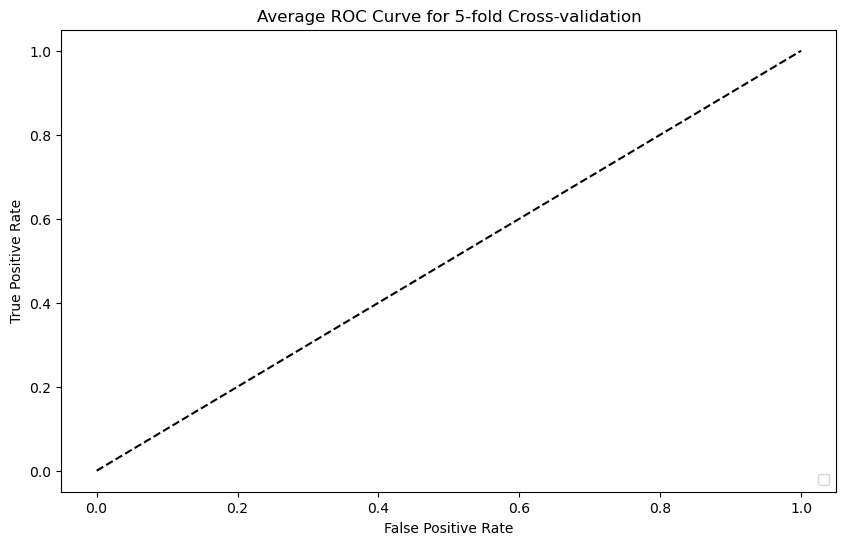

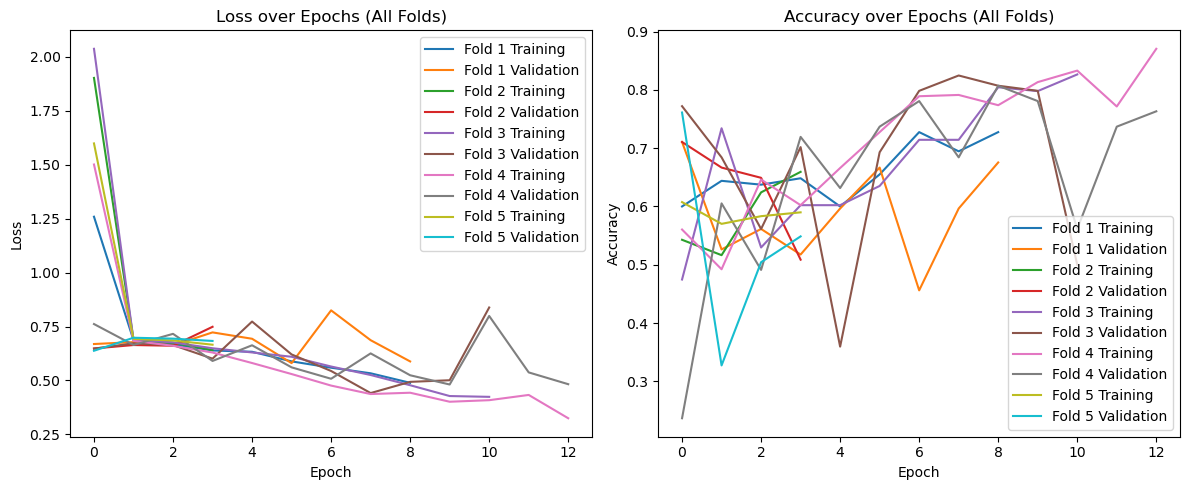


Summary Statistics Across All Folds:
       Accuracy  Precision    Recall  F1_Score  Test_Accuracy  Test_Loss  \
count  5.000000   5.000000  5.000000  5.000000       5.000000   5.000000   
mean   0.748704   0.785345  0.929332  0.844907      74.870362  55.787938   
std    0.061479   0.086332  0.097594  0.039713       6.147882   9.278412   
min    0.666667   0.710526  0.781609  0.788889      66.666669  44.162181   
25%    0.710526   0.717172  0.876543  0.830769      71.052629  48.133656   
50%    0.761062   0.761062  0.988506  0.844720      76.106197  58.040041   
75%    0.780702   0.819048  1.000000  0.864322      78.070176  63.771689   
max    0.824561   0.918919  1.000000  0.895833      82.456142  64.832121   

       Validation_Accuracy  Validation_Loss  Cohens_Kappa  \
count             5.000000         5.000000      5.000000   
mean              0.599208         0.668231      0.176604   
std               0.115397         0.138193      0.230265   
min               0.500000       

In [57]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
                             cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score, roc_curve, auc)
import matplotlib.pyplot as plt
import cv2
import os
import time

# ---------------------------
# Model definition function
# ---------------------------
def create_model():
    model = models.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ---------------------------
# Data preprocessing function
# ---------------------------
def preprocess_images(images):
    resized = np.array([cv2.resize(img, (150, 150)) for img in images])
    return np.repeat(resized[..., np.newaxis], 3, -1)

# ---------------------------
# Metrics calculation function
# ---------------------------
def calculate_metrics(y_true, y_pred, y_pred_prob, model, X_val, history):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    test_loss, test_accuracy = model.evaluate(X_val, y_true, verbose=0)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Test_Accuracy': test_accuracy * 100,
        'Test_Loss': test_loss * 100,
        'Validation_Accuracy': history.history['val_accuracy'][-1],
        'Validation_Loss': history.history['val_loss'][-1],
        'Cohens_Kappa': kappa,
        'Matthews_Correlation': mcc,
        'Balanced_Accuracy': balanced_acc,
        'True_Positives': tp,
        'True_Negatives': tn,
        'False_Positives': fp,
        'False_Negatives': fn,
        'ROC_AUC': roc_auc
    }

# ---------------------------
# Cross-validation function
# ---------------------------
def run_cross_validation(images, labels, n_folds=5, epochs=20):
    start_time = time.time()
    all_metrics = []
    fold_histories = []

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(images), 1):
        print(f'\nFold {fold}/{n_folds}')

        X_train, X_val = images[train_idx], images[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        # Preprocess images
        X_train_processed = preprocess_images(X_train) / 255.0
        X_val_processed = preprocess_images(X_val) / 255.0

        # Create model
        model = create_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Compute class weights
        class_weights_array = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights_dict = dict(enumerate(class_weights_array))
        print(f"Class Weights for Fold {fold}: {class_weights_dict}")

        # Train
        history = model.fit(X_train_processed, y_train,
                            epochs=epochs,
                            batch_size=32,
                            validation_data=(X_val_processed, y_val),
                            callbacks=[early_stopping],
                            class_weight=class_weights_dict,
                            verbose=1)

        fold_histories.append(history.history)

        # Predict
        val_pred_prob = model.predict(X_val_processed)
        val_pred = (val_pred_prob > 0.5).astype(int)

        # Metrics
        metrics = calculate_metrics(y_val, val_pred, val_pred_prob, model, X_val_processed, history)
        metrics['Fold'] = fold
        all_metrics.append(metrics)

        # Save model of the last fold
        if fold == n_folds:
            model.save(f'cnn_final_model_fold{fold}.h5')
            print(f"Model for fold {fold} saved as cnn_final_model_fold{fold}.h5")

    execution_time = time.time() - start_time
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df['Total_Execution_Time'] = execution_time

    return metrics_df, fold_histories

# ---------------------------
# Plotting function
# ---------------------------
def plot_results(fold_histories, metrics_df, n_folds):
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Average ROC Curve for {n_folds}-fold Cross-validation')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i, history in enumerate(fold_histories, 1):
        plt.plot(history['loss'], label=f'Fold {i} Training')
        plt.plot(history['val_loss'], label=f'Fold {i} Validation')
    plt.title('Loss over Epochs (All Folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i, history in enumerate(fold_histories, 1):
        plt.plot(history['accuracy'], label=f'Fold {i} Training')
        plt.plot(history['val_accuracy'], label=f'Fold {i} Validation')
    plt.title('Accuracy over Epochs (All Folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nSummary Statistics Across All Folds:")
    print(metrics_df.describe())

# ---------------------------
# Main execution
# ---------------------------
if __name__ == "__main__":
    # Make sure images and labels are loaded before
    # images = np.array(images)
    # labels = np.array(labels)

    fold_values = [5]
    for n_folds in fold_values:
        print(f"\nRunning {n_folds}-fold cross-validation")
        metrics_df, fold_histories = run_cross_validation(images, labels, n_folds=n_folds)

        metrics_df.to_csv(f'CNN_metrics_{n_folds}fold_epoch20.csv', index=False)
        plot_results(fold_histories, metrics_df, n_folds)


In [45]:
def load_images_from_folder(folder, target_size=(150, 150)):
    images = []
    labels = []
    
    for label_name in ['Negatives', 'Positives']:
        path = os.path.join(folder, label_name)
        label = 0 if label_name == 'Negatives' else 1
        
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Skipping unreadable image: {img_path}")
                continue
            try:
                img_resized = cv2.resize(img, target_size)
                images.append(img_resized)
                labels.append(label)
            except Exception as e:
                print(f"Skipping image due to error: {img_path}, {e}")
    
    return np.array(images), np.array(labels)


In [47]:
images, labels = load_images_from_folder('/Users/yanthraa/Desktop/PROJECT/NEW DATASET/archive')
print("Images shape:", images.shape)
print("Labels count:", np.bincount(labels))


Skipping unreadable image: /Users/yanthraa/Desktop/PROJECT/NEW DATASET/archive/Positives/.ipynb_checkpoints
Images shape: (569, 150, 150)
Labels count: [147 422]
